# Introduction
## Problem Description

My stakeholder plans to open a restaurant in Manhattan. Being an entrepreneur, and not a cook, he wants to understand what type of restaurant is most convenient to open and in which area of Manhattan. Maybe a Chinese or Italian restaurant? So first of all he wants to understand in the different areas of Manhattan what is the characteristic or more present cuisine, because this certainly reflects the culture of those who live in those areas. Once he understand this, he would like to identify an area of Manhattan where most popular characteristic restaurants have a low number of likes on the social networks anyway, so he can open your restaurant right there. In fact, my stakeholder has a very competent social marketing team at his disposal, so he wants to exploit this potential. By opening a very common typical restaurant in an area where his competitors are not very active on social networks, he thinks he can be successful by involving his customers, who by culture prefer that type of cuisine, using social networks. 


## Data Description
To meet my stakeholder's request I intend to identify clusters of neighborhoods based on their cuisine using Foursquare APIs. Once I have identified the most present cuisine in each cluster, I intend to use again the Foursquare APIs in order to find out which is the cuisine-cluster couple that collects the fewest number of likes, so that I can tell my stakeholder to open a restaurant with that typical cuisine in that cluster. Foursquare venue details API will be used for this purpose, since they provide the number of likes collected by the venue together with other venue details. 

## Methodology
I will use the dataset available at https://cocl.us/new_york_dataset in order to find out NYC neighborhoods data. I will filter this dataset in order to focus only on Manhattan neighborhoods. After that I will use the Foursquare APIs in order to find out venues in Manhattan neighborhoods which category type is food (category id = 4d4b7105d754a06374d81259).
At this point I will use again the Foursquare APIs in order to find the number of likes received by each of those venues. In the end I will apply the K-Means Clustering in order to identify the 2 most popular and characteristic cuisines of each cluster, in order to focus my attention on this type of cuisines in that specific clusters. Once identified the most popular cuisines of each cluster, I will calculate the mean number of likes collected by those type of restaurants in those areas and I will indicate to my Stakeholder to open a new restaurant basing on the couple cluster-cuisine which has the lowest mean number of likes collected. 

## Discussion
The are the obtained results for the 2 most common restaurants in identified cluster0 and cluster1:
- mean italian restaurant likes in C1: 10.157894736842104
- mean american restaurant likes in C1: 4.4
- mean mexican restaurant likes in C0: 0.0
- mean chinese restaurant likes in C0: 0.0
Since we are using the free version of Foursquare APIs, not all the venus likes are retrieved, because we have to make too many calls in order to retrieve all venues details. For this reason the likes count for cluster0 (C0) is always 0.0. For the seek of simplicity we assume that mean number of likes for Mexican and Chinese restaurants in C0 is 20. 

## Results
Once executed the analysis, I find out that the best choice for my Stakeholder is to open the new restaurant considering the couple cluster 1 - american cuisine, so he can exploit his potential in social marketing and make sure to open a typical restaurant characteristic for that area.


In [1]:
import pandas as pd
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

#### load NYC neighborhoods data into a Pandas dataframe. Dataframe columns:
- Borough
- Neighborhood
- Latitude
- Longitude

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### filter dataset rows in order to focus only on Manhattan borough and on its neighborhoods

In [8]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### retrieve Manhattan coordinates using geolocator

In [9]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


#### create the map of Manhattan using Folium library. The map shows the borough of Manhattan and use markers in order to point out its neighborhoods

In [10]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### define Foursquare APIs credentials in order to make following API calls to the service

In [66]:
CLIENT_ID = 'J0V1HGAQ3BL45OMZ11SVZ54JQMGUFOLRMCFN25MA0EQTBIFB' # your Foursquare ID
CLIENT_SECRET = 'VBSDZUPBWY0HNRHLZA3EID1CD3IQHOVY3KAKZIO4OOLKU4CS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J0V1HGAQ3BL45OMZ11SVZ54JQMGUFOLRMCFN25MA0EQTBIFB
CLIENT_SECRET:VBSDZUPBWY0HNRHLZA3EID1CD3IQHOVY3KAKZIO4OOLKU4CS


In [58]:
manhattan_data.loc[0, 'Neighborhood']

neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### retrieve venues in Manhattan neighborhoods using Foursquare API. *Note: the last parameter indicates the Category ID for Food Category in order to retrieve only food venues we are interested in*

In [13]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
    '4d4b7105d754a06374d81259')
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=4IZHTCZPM3W0P135TEVFVUVCJ1QHDHXHH3OIFJJZF3OWOWNN&client_secret=HOCOCALVJLZRD3BGEZSMPY1IALR3MWYM0LUG5LWU0NVZQJMW&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100&categoryId=4d4b7105d754a06374d81259'

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef8611334f8b76b95f8fa65'},
 'response': {'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'query': 'food',
  'totalResults': 14,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.87441177110231,
          'lng': -73.91027100981574},


#### load results in a Pandas dataframe with the following columns:
- venue Id
- venue Name
- venue Category
- venue Latitude
- venue Longitude
*note that values in venue category columns has to be cleaned in order to show only the specific category, e.g. Mexican Restaurant*

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues

,venue.id,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,4b4429abf964a52037f225e3,Arturo's,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",40.874412,-73.910271
1,4b79cc46f964a520c5122fe3,Tibbett Diner,"[{'id': '4bf58dd8d48988d147941735', 'name': 'D...",40.880404,-73.908937
2,4b5357adf964a520319827e3,Dunkin',"[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",40.877136,-73.906666
3,4d0a529133d6b60cf4cf9985,Subway,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.874832,-73.909950
4,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,"[{'id': '4bf58dd8d48988d1ce941735', 'name': 'S...",40.877885,-73.905873
5,4b4f7b65f964a5205a0827e3,Subway Sandwiches,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.874667,-73.909586
6,585c205665e7c70a2f1055ea,Boston Market,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",40.877430,-73.905412
7,4e4ce4debd413c4cc66d05d0,Subway,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.878465,-73.905518
8,4dfe40df8877333e195b68fc,Parrilla Latina,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",40.877473,-73.906073
9,4f00ce265c5c51dd2f44809c,Hernandez Grocery,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",40.875965,-73.912994


In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
# filter the category for each row

categories = nearby_venues.apply(get_category_type, axis=1)

#### once the category values are cleaned, the dataframe shows all needed infromations. *Note that in dataframe we have all the venues from the Food category, but we want to focus only on Restaurants, so further on we will filter out unrelevant rows*

In [18]:
nearby_venues['venue.categories'] = categories
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,id,name,categories,lat,lng
0,4b4429abf964a52037f225e3,Arturo's,Pizza Place,40.874412,-73.910271
1,4b79cc46f964a520c5122fe3,Tibbett Diner,Diner,40.880404,-73.908937
2,4b5357adf964a520319827e3,Dunkin',Donut Shop,40.877136,-73.906666
3,4d0a529133d6b60cf4cf9985,Subway,Sandwich Place,40.874832,-73.909950
4,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,Seafood Restaurant,40.877885,-73.905873
5,4b4f7b65f964a5205a0827e3,Subway Sandwiches,Sandwich Place,40.874667,-73.909586
6,585c205665e7c70a2f1055ea,Boston Market,American Restaurant,40.877430,-73.905412
7,4e4ce4debd413c4cc66d05d0,Subway,Sandwich Place,40.878465,-73.905518
8,4dfe40df8877333e195b68fc,Parrilla Latina,Steakhouse,40.877473,-73.906073
9,4f00ce265c5c51dd2f44809c,Hernandez Grocery,Deli / Bodega,40.875965,-73.912994


In [19]:
def getNearbyFood(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            '4d4b7105d754a06374d81259')
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'VenueId',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
# type your answer here

manhattan_venues = getNearbyFood(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [21]:
print(manhattan_venues.shape)
manhattan_venues.head()

(2744, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueId,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,4b4429abf964a52037f225e3,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,4b79cc46f964a520c5122fe3,Tibbett Diner,40.880404,-73.908937,Diner
2,Marble Hill,40.876551,-73.91066,4b5357adf964a520319827e3,Dunkin',40.877136,-73.906666,Donut Shop
3,Marble Hill,40.876551,-73.91066,4d0a529133d6b60cf4cf9985,Subway,40.874832,-73.909950,Sandwich Place
4,Marble Hill,40.876551,-73.91066,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant


#### filter out venues not belonging to Restaurant category

In [74]:
manhattan_restaurants = manhattan_venues.loc[manhattan_venues['Venue Category'].str.contains('Restaurant')]

manhattan_restaurants = manhattan_restaurants.loc[manhattan_restaurants['Venue Category'] != 'Restaurant']


#### we need another information: number of likes received by each venue from the social networks, so we add a new column to the dataframe, namely *likesCount*. In order to populate this column we need to make a Foursquared API call for each venue.

In [75]:
manhattan_restaurants['likesCount'] = 0
manhattan_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueId,Venue,Venue Latitude,Venue Longitude,Venue Category,likesCount
4,Marble Hill,40.876551,-73.910660,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,0
6,Marble Hill,40.876551,-73.910660,585c205665e7c70a2f1055ea,Boston Market,40.877430,-73.905412,American Restaurant,0
11,Marble Hill,40.876551,-73.910660,4b5e451cf964a520f58629e3,Applebee's Grill + Bar,40.873685,-73.908928,American Restaurant,0
13,Marble Hill,40.876551,-73.910660,5012c967e889cf0567e9e2d4,Grill 26 at TCR,40.878802,-73.915672,American Restaurant,0
16,Chinatown,40.715618,-73.994279,5521c2ff498ebe2368634187,Kiki's,40.714476,-73.992036,Greek Restaurant,0
17,Chinatown,40.715618,-73.994279,4db3374590a0843f295fb69b,Spicy Village,40.717010,-73.993530,Chinese Restaurant,0
18,Chinatown,40.715618,-73.994279,4c9d482e46978cfa8247967f,The Fat Radish,40.715323,-73.991950,English Restaurant,0
21,Chinatown,40.715618,-73.994279,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店,40.717278,-73.994177,Chinese Restaurant,0
22,Chinatown,40.715618,-73.994279,5d992946dbf3ca0008d05211,Da Yu Hot Pot 大渝火锅,40.716735,-73.995752,Hotpot Restaurant,0
24,Chinatown,40.715618,-73.994279,4fd38a04e4b065401a9aaf88,Forgtmenot,40.714459,-73.991546,New American Restaurant,0


#### retrieve *likesCount* using Foursquare venue detail API for each collected venue

In [93]:
for index, row in manhattan_restaurants.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            row['VenueId'],
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)
    response = requests.get(url).json()["response"]
    try:
        manhattan_restaurants.set_value(index,'likesCount', response['venue']['likes']['count'])
    except:
        row['likesCount'] = 0

#### resulting dataset now contains all needed information, also with likesCount value for each collected venue

In [95]:
manhattan_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,VenueId,Venue,Venue Latitude,Venue Longitude,Venue Category,likesCount
4,Marble Hill,40.876551,-73.910660,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,42
6,Marble Hill,40.876551,-73.910660,585c205665e7c70a2f1055ea,Boston Market,40.877430,-73.905412,American Restaurant,4
11,Marble Hill,40.876551,-73.910660,4b5e451cf964a520f58629e3,Applebee's Grill + Bar,40.873685,-73.908928,American Restaurant,52
13,Marble Hill,40.876551,-73.910660,5012c967e889cf0567e9e2d4,Grill 26 at TCR,40.878802,-73.915672,American Restaurant,1
16,Chinatown,40.715618,-73.994279,5521c2ff498ebe2368634187,Kiki's,40.714476,-73.992036,Greek Restaurant,830
17,Chinatown,40.715618,-73.994279,4db3374590a0843f295fb69b,Spicy Village,40.717010,-73.993530,Chinese Restaurant,500
18,Chinatown,40.715618,-73.994279,4c9d482e46978cfa8247967f,The Fat Radish,40.715323,-73.991950,English Restaurant,716
21,Chinatown,40.715618,-73.994279,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店,40.717278,-73.994177,Chinese Restaurant,192
22,Chinatown,40.715618,-73.994279,5d992946dbf3ca0008d05211,Da Yu Hot Pot 大渝火锅,40.716735,-73.995752,Hotpot Restaurant,16
24,Chinatown,40.715618,-73.994279,4fd38a04e4b065401a9aaf88,Forgtmenot,40.714459,-73.991546,New American Restaurant,517


#### check how many unique categories can be curated from all the returned venues

In [96]:
print('There are {} uniques categories.'.format(len(manhattan_restaurants['Venue Category'].unique())))

There are 88 uniques categories.


#### perform one-hot-encoding in order to apply the KMeans Clustering algo

In [97]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Marble Hill,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,Marble Hill,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Marble Hill,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### group rows by neighborhood and calculate mean of categories in that neighborhood

In [98]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Battery Park City,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Carnegie Hill,0.000000,0.000000,0.052632,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632
2,Central Harlem,0.000000,0.136364,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000
3,Chelsea,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.044444,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.022222
4,Chinatown,0.000000,0.000000,0.042857,0.000000,0.000000,0.028571,0.014286,0.014286,0.000000,...,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.071429
5,Civic Center,0.000000,0.000000,0.106383,0.000000,0.000000,0.042553,0.021277,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277
6,Clinton,0.000000,0.000000,0.156863,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.078431,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000
7,East Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,East Village,0.000000,0.000000,0.041096,0.013699,0.013699,0.013699,0.000000,0.000000,0.000000,...,0.013699,0.000000,0.013699,0.000000,0.000000,0.013699,0.013699,0.082192,0.000000,0.041096
9,Financial District,0.000000,0.000000,0.139535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [99]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### put top 2 common venues for each neighborhood into a pandas dataframe

In [100]:
num_top_venues = 2

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
0,Battery Park City,Chinese Restaurant,Italian Restaurant
1,Carnegie Hill,Sushi Restaurant,Italian Restaurant
2,Central Harlem,Southern / Soul Food Restaurant,African Restaurant
3,Chelsea,French Restaurant,American Restaurant
4,Chinatown,Chinese Restaurant,Vietnamese Restaurant


### Elbow Method

**Represent performed clusters in order to choose the best number of clusters (K starting value for KMeans) using Elbow Method.**

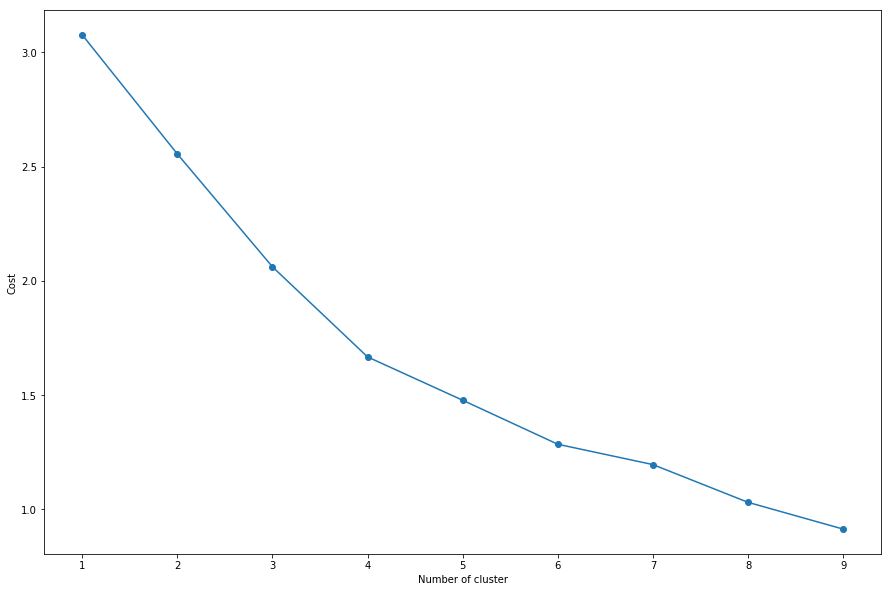

In [101]:
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

def n_clusters(last, df, km=[], res_clust=[], first=1):
    for n in range(first, last+1):
        n_clusters = n
        km.append(KMeans(n_clusters=n_clusters, random_state=0))
        res_clust.append(km[n-1].fit_predict(df))
        print( )
    return km, res_clust

centroids = []
km, clusters = n_clusters(10, manhattan_grouped_clustering)

sse = {}
for k in range (1, len(km)):
    sse[k] = km[k-1].inertia_
fig = plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of cluster")
plt.ylabel("Cost")
plt.show()

### As shown by the chart, the best value (according with the Elbow Method) for initializing K is 3
**perform KMeans Clustering with K=3**

In [107]:
# set number of clusters
kclusters = 3

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=7).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:3] 

array([0, 2, 0], dtype=int32)

#### add clustering information into dataframe

In [112]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels 3', kmeans.labels_)
del neighborhoods_venues_sorted['Cluster Labels 2']
del neighborhoods_venues_sorted['Cluster Labels']


manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels 3,1st Most Common Venue,2nd Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,American Restaurant,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Vietnamese Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Chinese Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Chinese Restaurant


In [113]:
manhattan_merged['Cluster Labels 3'].value_counts()

2    24
0    15
1     1
Name: Cluster Labels 3, dtype: int64

In [114]:
manhattan_merged = manhattan_merged.loc[manhattan_merged['Cluster Labels 3'] != 1]
manhattan_merged['Cluster Labels 3'].value_counts()

2    24
0    15
Name: Cluster Labels 3, dtype: int64

#### Finally, let's visualize the resulting clusters using Folium maps¶

In [115]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels 3']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### show cluster 0 

In [118]:
cluster_0 = manhattan_merged.loc[manhattan_merged['Cluster Labels 3'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [119]:
cluster_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
1,Chinatown,Chinese Restaurant,Vietnamese Restaurant
2,Washington Heights,Chinese Restaurant,Mexican Restaurant
3,Inwood,Mexican Restaurant,Spanish Restaurant
4,Hamilton Heights,Mexican Restaurant,Chinese Restaurant
5,Manhattanville,Chinese Restaurant,Seafood Restaurant
6,Central Harlem,Southern / Soul Food Restaurant,African Restaurant
7,East Harlem,Mexican Restaurant,Latin American Restaurant
11,Roosevelt Island,Japanese Restaurant,Chinese Restaurant
19,East Village,Vegetarian / Vegan Restaurant,Japanese Restaurant
20,Lower East Side,Chinese Restaurant,Mexican Restaurant


#### show cluster 1

In [121]:
cluster_1 = manhattan_merged.loc[manhattan_merged['Cluster Labels 3'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [122]:
cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
8,Upper East Side,Italian Restaurant,American Restaurant
9,Yorkville,Italian Restaurant,Sushi Restaurant
10,Lenox Hill,Italian Restaurant,Sushi Restaurant
12,Upper West Side,Italian Restaurant,Indian Restaurant
13,Lincoln Square,Italian Restaurant,American Restaurant
14,Clinton,Italian Restaurant,American Restaurant
15,Midtown,American Restaurant,Japanese Restaurant
16,Murray Hill,Japanese Restaurant,American Restaurant
17,Chelsea,French Restaurant,American Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant


#### check most common restaurants in cluster 0

In [123]:
cols = cluster_0.columns.tolist()
cols.remove('Neighborhood')
for col in cols:
    print(cluster_0[col].value_counts(ascending=False))

Chinese Restaurant                 5
Mexican Restaurant                 4
Southern / Soul Food Restaurant    1
Japanese Restaurant                1
Greek Restaurant                   1
Korean Restaurant                  1
Vegetarian / Vegan Restaurant      1
American Restaurant                1
Name: 1st Most Common Venue, dtype: int64
Mexican Restaurant           3
Chinese Restaurant           3
Japanese Restaurant          2
African Restaurant           1
Spanish Restaurant           1
Seafood Restaurant           1
Indian Restaurant            1
Latin American Restaurant    1
Vietnamese Restaurant        1
Italian Restaurant           1
Name: 2nd Most Common Venue, dtype: int64


#### check most common restaurants in cluster 1

In [124]:
cols = cluster_1.columns.tolist()
cols.remove('Neighborhood')
for col in cols:
    print(cluster_1[col].value_counts(ascending=False))

Italian Restaurant     18
Sushi Restaurant        2
American Restaurant     2
French Restaurant       1
Japanese Restaurant     1
Name: 1st Most Common Venue, dtype: int64
American Restaurant         11
Sushi Restaurant             4
Japanese Restaurant          2
Italian Restaurant           2
German Restaurant            1
Chinese Restaurant           1
Indian Restaurant            1
French Restaurant            1
Mediterranean Restaurant     1
Name: 2nd Most Common Venue, dtype: int64


#### calculate mean number of likes for most common restaurant type in cluster 0

In [128]:
italian_restaurants = manhattan_restaurants.loc[manhattan_restaurants['Venue Category'] == 'Italian Restaurant']
american_restaurants = manhattan_restaurants.loc[manhattan_restaurants['Venue Category'] == 'American Restaurant']
mean_likes_italian_cluster_1 = italian_restaurants.loc[italian_restaurants['Neighborhood'].isin(cluster_0['Neighborhood'].tolist()),'likesCount'].mean()
mean_likes_american_cluster_1 = american_restaurants.loc[american_restaurants['Neighborhood'].isin(cluster_0['Neighborhood'].tolist()),'likesCount'].mean()

#### calculate mean number of likes for most common restaurant type in cluster 1

In [129]:
mexican_restaurants = manhattan_venues.loc[manhattan_venues['Venue Category'] == 'Mexican Restaurant']
chinese_restaurants = manhattan_venues.loc[manhattan_venues['Venue Category'] == 'Chinese Restaurant']
mean_likes_mexican_cluster_0 = mexican_restaurants.loc[mexican_restaurants['Neighborhood'].isin(cluster_0['Neighborhood'].tolist()),'likesCount'].mean()
mean_likes_chinese_cluster_0 = chinese_restaurants.loc[chinese_restaurants['Neighborhood'].isin(cluster_0['Neighborhood'].tolist()),'likesCount'].mean()

#### show mean number of likes for most common restaurant in clusters

In [130]:
print('mean italian restaurant likes in C1:', mean_likes_italian_cluster_1)
print('mean american restaurant likes in C1:', mean_likes_american_cluster_1)
print('mean mexican restaurant likes in C0:', mean_likes_mexican_cluster_0)
print('mean chinese restaurant likes in C0:', mean_likes_chinese_cluster_0)

mean italian restaurant likes in C1: 10.157894736842104
mean american restaurant likes in C1: 4.4
mean mexican restaurant likes in C0: 0.0
mean chinese restaurant likes in C0: 0.0


## Conclusion: 
#### since we are using a free version of Foursquare APIs we cannot retrieve likesCount for each venue, so at the end we have restaurants from cluster 0 with mean number of likes equal to 0. For the seek of simplicity let's assume that those restaurants (mexican and chinese in cluster 0) has mean number of likes equal to 20.
#### So at the end we can say that the best choice for our customer is to open an American Restaurant in any place in Cluster 1 in order to choose a type of cuisine characteristic of the area and to exploit is potential in social marketing. 